In [25]:
import pyes
import json
from pyes import ES,MatchAllQuery
from pyes.aggs import TermsAgg, HistogramAgg
from pyes.query import RangeQuery, NestedQuery
from pyes.utils import ESRange
import pandas as pd
from datetime import datetime

es_address='140.118.126.240:9200'

conn=pyes.es.ES(es_address)

bq = pyes.BoolQuery()
tsf = pyes.filters.TermsFilter(field="text", values=["cve","overflow","aslr","pwn","shellcode","vulnerability","security","ctf","exploit","rce"])
fq = pyes.query.FilteredQuery(pyes.query.MatchAllQuery(), tsf)


bq.add_should(fq)

rq = RangeQuery(qrange=ESRange(field="created_at",from_value=1388567481537,to_value=1420017981537))
bq.add_must(rq)

qsearch = pyes.query.Search(bq) 
tagg = pyes.aggs.CardinalityAgg('uid', field = 'uid') 
qsearch.agg.add(tagg)

rs = conn.search(query=qsearch, indices='twitter2' , type="tweet")
print "1: ",json.dumps(rs.aggs,indent=4)
print "2: ",len(rs)
total = len(rs)


1:  {
    "uid": {
        "value": 102
    }
}
2:  5080


4:


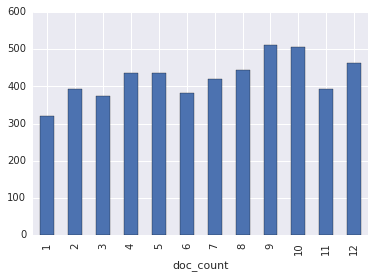

In [26]:
import matplotlib
matplotlib.use('agg')
import matplotlib.pyplot as plt
import seaborn as sns
qsearch_2 = pyes.query.Search(bq) 
DHAgg = pyes.aggs.DateHistogramAgg('by_month' ,field='created_at', interval='month', sub_aggs=[])
qsearch_2.agg.add(DHAgg)

rs = conn.search(query=qsearch_2, indices='twitter2' , type="tweet")
# print json.dumps(rs.aggs,indent=4)
month_data = pd.read_json(json.dumps(rs.aggs["by_month"]["buckets"]))
# print json.dumps(rs.aggs["by_month"])
%matplotlib inline
type (month_data)
month_data.index = month_data.index + 1  # shifting index
sns.distplot(month_data['doc_count'])
print "4:"
month_data['doc_count'].plot.bar()
sns.plt.show()
# sns.boxplot()


/opt/conda/lib/python2.7/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


3: 


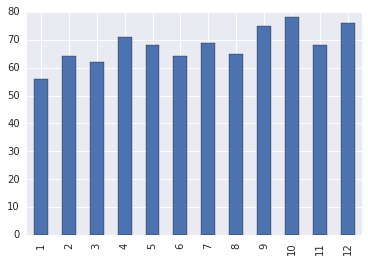

In [27]:
DHAgg.sub_aggs.append(tagg)
qsearch_3 = pyes.query.Search(bq) 
qsearch_3.agg.add(DHAgg)
rs = conn.search(query=qsearch_3, indices='twitter2' , type="tweet")
month_data = pd.read_json(json.dumps(rs.aggs["by_month"]["buckets"]))
# month_data['uid'][0]['value']
for i in range(0,12):
    month_data['uid'][i] = month_data['uid'][i]['value']

month_data.index = month_data.index + 1  # shifting index
print "3: "
month_data['uid'].plot.bar()
sns.plt.show()

5: 


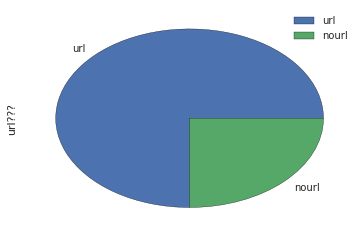

In [51]:
# from elasticsearch import Elasticsearch

# response = client.search(
#     index="twitter2",
#     body={
#       "query": {
#         "nested": {
#           "path": "entities",
#           "query": {
#             "match_all": {}
#           },
#           "filter": {
#             "exists": {
#               "field": "entities.urls"
#             }
#           }
#         }
#       }
#     }
# )



qsearch_4 = pyes.query.Search(bq) 
hagg = HistogramAgg('url', field = "entities.urls.indices", interval = 1000) 
qsearch_4.agg.add(hagg)

rs = conn.search(query=qsearch_4, indices='twitter2' , type="tweet")
urls = pd.read_json(json.dumps(rs.aggs["url"]["buckets"]))
with_url = urls["doc_count"][0]
without_url = total - with_url;

d = {'url???': [with_url*100/total, 100-with_url*100/total]}
df = pd.DataFrame(data=d, index=['url','nourl'])
print "5: "
df.plot.pie(subplots=True)
sns.plt.show()